In [1]:
print("hello")

hello


In [7]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

# Jupyter Notebook Setup
To run Jupyter notebook with Colab integration, use this command in terminal:
```bash
jupyter notebook \
    --NotebookApp.allow_origin='https://colab.research.google.com' \
    --port=8888 \
    --NotebookApp.port_retries=0 \
    --NotebookApp.allow_credentials=True
```

In [10]:
DATASET_DIR = r"C:\Users\chall\OneDrive\Desktop\final project\ibug_300W_large_face_landmark_dataset"
ARCHIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset.tar.gz"

if not os.path.exists(DATASET_DIR):
    !tar -xvzf "$ARCHIVE_PATH" -C "/content/drive/MyDrive/Colab Notebooks"


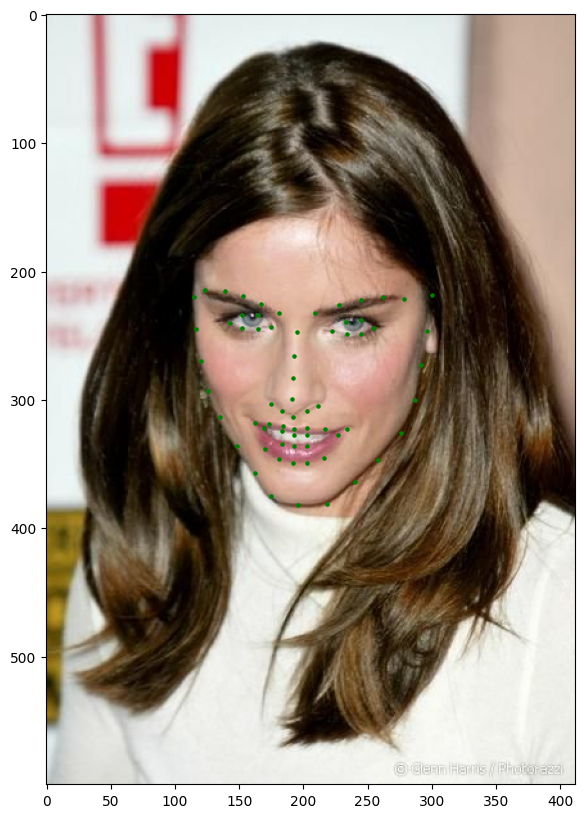

In [18]:
pts_file_path = os.path.join(r'C:\Users\chall\OneDrive\Desktop\final project\ibug_300W_large_face_landmark_dataset\ibug_300W_large_face_landmark_dataset', 'lfpw', 'trainset', 'image_0001.pts')
image_file_path = os.path.join(r'C:\Users\chall\OneDrive\Desktop\final project\ibug_300W_large_face_landmark_dataset\ibug_300W_large_face_landmark_dataset', 'lfpw', 'trainset', 'image_0001.png')

file = open(pts_file_path)
points = file.readlines()[3:-1]

landmarks = []

for point in points:
    x,y = point.split(' ')
    landmarks.append([floor(float(x)), floor(float(y[:-1]))])

landmarks = np.array(landmarks)

plt.figure(figsize=(10,10))
plt.imshow(mpimg.imread(image_file_path))
plt.scatter(landmarks[:,0], landmarks[:,1], s = 5, c = 'g')
plt.show()

In [19]:
class Transforms():
    def __init__(self):
        pass

    def rotate(self, image, landmarks, angle):
        # image (PIL.Image), landmarks (torch.tensor, absolute pixels for image.width, image.height)
        angle = random.uniform(-angle, +angle)

        # To rotate landmarks around image center
        center_x, center_y = image.width / 2, image.height / 2

        # Shift landmarks so center of image is origin
        landmarks_centered = landmarks - torch.tensor([[center_x, center_y]])

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))],
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        # Rotate landmarks
        new_landmarks_centered = torch.matmul(landmarks_centered.float(), transformation_matrix.float())

        # Shift landmarks back
        new_landmarks = new_landmarks_centered + torch.tensor([[center_x, center_y]])

        # Rotate image (imutils.rotate operates on numpy array, so convert PIL to numpy and back)
        image_np = np.array(image)
        image_rotated_np = imutils.rotate(image_np, angle)
        image_rotated = Image.fromarray(image_rotated_np)

        return image_rotated, new_landmarks

    def resize(self, image, landmarks, img_size):
        # image (PIL.Image), landmarks (torch.tensor, absolute pixels for image.width, image.height)
        # img_size is (new_width, new_height) e.g., (224, 224)
        old_width, old_height = image.width, image.height
        new_width, new_height = img_size

        image = TF.resize(image, img_size) # Image is now (new_width, new_height)

        # Scale landmarks to new image size
        landmarks[:, 0] = landmarks[:, 0] * (new_width / old_width)
        landmarks[:, 1] = landmarks[:, 1] * (new_height / old_height)

        return image, landmarks # landmarks are now absolute pixels for new_width, new_height

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.3,
                                              contrast=0.3,
                                              saturation=0.3,
                                              hue=0.1)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks, crops):
        # image (PIL.Image), landmarks (torch.tensor, absolute pixels for original image)
        left = int(crops['left'])
        top = int(crops['top'])
        width = int(crops['width'])
        height = int(crops['height'])

        image = TF.crop(image, top, left, height, width)

        # Adjust landmarks to be relative to the top-left of the cropped image
        landmarks = landmarks - torch.tensor([[left, top]])

        return image, landmarks # landmarks are now absolute pixels relative to the cropped image

    def __call__(self, image, landmarks, crops):
        # initial image is numpy array, landmarks are numpy array (absolute from XML)
        image = Image.fromarray(image)
        landmarks = torch.tensor(landmarks).float() # Convert landmarks to tensor early

        # 1. Crop face: image is cropped, landmarks adjusted to cropped coords (absolute pixels)
        image, landmarks = self.crop_face(image, landmarks, crops)

        # 2. Resize image and scale landmarks (landmarks are still absolute pixels for the new 224x224 image)
        image, landmarks = self.resize(image, landmarks, (224, 224))

        # 3. Color Jitter
        image, landmarks = self.color_jitter(image, landmarks)

        # 4. Rotate image and landmarks (landmarks are absolute pixels for 224x224)
        image, landmarks = self.rotate(image, landmarks, angle=10)

        # Final conversion to tensor and normalization for image
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])

        # Final normalization for landmarks to [-0.5, 0.5] for the model output
        # Landmarks are currently absolute pixel values for a 224x224 image.
        # Normalize them to [0,1] then shift to [-0.5,0.5]
        landmarks = landmarks / torch.tensor([224.0, 224.0]) # Normalize to [0,1] relative to 224x224
        landmarks = landmarks - 0.5 # Shift to [-0.5, 0.5]

        return image, landmarks

In [ ]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, transform=None):

        xml_file_path = os.path.join(r'C:\Users\chall\OneDrive\Desktop\final project\ibug_300W_large_face_landmark_dataset\ibug_300W_large_face_landmark_dataset', 'labels_ibug_300W_train.xml')
        tree = ET.parse(xml_file_path)
        root = tree.getroot()

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        # Use the local dataset directory path
        self.root_dir = r'C:\Users\chall\OneDrive\Desktop\final project\ibug_300W_large_face_landmark_dataset\ibug_300W_large_face_landmark_dataset'

        for filename in root[2]:
            self.image_filenames.append(os.path.join(self.root_dir, filename.attrib['file']))

            self.crops.append(filename[0].attrib)

            landmark = []
            for num in range(68):
                x_coordinate = int(filename[0][num].attrib['x'])
                y_coordinate = int(filename[0][num].attrib['y'])
                landmark.append([x_coordinate, y_coordinate])
            self.landmarks.append(landmark)

        self.landmarks = np.array(self.landmarks).astype('float32')

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self,):
        return len(self.image_filenames)

    def __getitem__(self, index):
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]

        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        # This line is removed as normalization to [-0.5, 0.5] is now handled in the Transforms.__call__ method
        # landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(Transforms())

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml'

In [ ]:
image, landmarks = dataset[0]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:,0], landmarks[:,1], s=8);

In [ ]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=8, shuffle=True, num_workers=4)

In [ ]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

In [ ]:
class Network(nn.Module):
    def __init__(self,num_classes=136):
        super().__init__()
        self.model_name='resnet18'
        self.model=models.resnet18()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x

In [ ]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))

    sys.stdout.flush()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#torch.autograd.set_detect_anomaly(True)

# Example: Replace with your actual model class
network = Network().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 5

start_time = time.time()

def print_overwrite(step, total, loss, mode):
    print(f"\r{mode.upper()} | Step [{step}/{total}] | Loss: {loss:.4f}", end='')

for epoch in range(1, num_epochs + 1):
    loss_train = 0.0
    loss_valid = 0.0

    # ==================== TRAINING ====================
    network.train()
    for step, (images, landmarks) in enumerate(train_loader, start=1):
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        optimizer.zero_grad()
        predictions = network(images)
        loss = criterion(predictions, landmarks)

        loss.backward()
        optimizer.step()

        loss_train += loss.item()
        if step % 20 == 0:
          print_overwrite(step, len(train_loader), loss_train / step, 'train')

    # ==================== VALIDATION ====================
    network.eval()
    with torch.no_grad():
        for step, (images, landmarks) in enumerate(valid_loader, start=1):
            images = images.to(device)
            landmarks = landmarks.view(landmarks.size(0), -1).to(device)

            predictions = network(images)
            loss = criterion(predictions, landmarks)

            loss_valid += loss.item()
            print_overwrite(step, len(valid_loader), loss_valid / step, 'valid')

    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)

    print('\n--------------------------------------------------')
    print(f'Epoch: {epoch}  Train Loss: {loss_train:.4f}  Valid Loss: {loss_valid:.4f}')
    print('--------------------------------------------------')

    # Save best model
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth')
        print(f"\nMinimum Validation Loss of {loss_min:.4f} at epoch {epoch}/{num_epochs}")
        print('Model Saved\n')

print('Training Complete')
print(f"Total Elapsed Time: {time.time() - start_time:.2f} s")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Evaluating on device: {device}")

best_model = Network().to(device)
best_model.load_state_dict(torch.load('/content/face_landmarks.pth'))
best_model.eval()

criterion = nn.MSELoss()

# ========== EVALUATION ==========
valid_losses = []
valid_distances = []

def mean_euclidean_distance(preds, targets):
    preds = preds.view(preds.size(0), -1, 2)
    targets = targets.view(targets.size(0), -1, 2)
    return torch.sqrt(((preds - targets) ** 2).sum(dim=2)).mean().item()

with torch.no_grad():
    for images, landmarks in valid_loader:
        images = images.to(device)
        landmarks = landmarks.view(landmarks.size(0), -1).to(device)

        predictions = best_model(images)
        loss = criterion(predictions, landmarks)
        distance = mean_euclidean_distance(predictions, landmarks)

        valid_losses.append(loss.item())
        valid_distances.append(distance)

avg_loss = np.mean(valid_losses)
avg_distance = np.mean(valid_distances)

print("\n==================== Evaluation Summary ====================")
print(f"Average Validation Loss     : {avg_loss:.4f}")
print(f"Mean Euclidean Distance (MED): {avg_distance:.4f} (lower = better)")
print("============================================================")

# ========== PLOTS ==========
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(valid_losses, label='Validation Loss per Batch')
plt.title('Validation Loss Curve')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(valid_distances, label='Validation Accuracy (MED)', color='orange')
plt.title('Validation Accuracy Curve')
plt.xlabel('Batch')
plt.ylabel('Mean Euclidean Distance')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
import time
import torch
import matplotlib.pyplot as plt

start_time = time.time()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with torch.no_grad():
    best_network = Network().to(device)
    best_network.load_state_dict(torch.load('/content/face_landmarks.pth', map_location=device))
    best_network.eval()

    images, landmarks = next(iter(valid_loader))
    images, landmarks = images.to(device), landmarks.to(device)

    landmarks = (landmarks + 0.5) * 224
    predictions = (best_network(images) + 0.5) * 224
    predictions = predictions.view(-1, 68, 2).cpu()
    images = images.cpu()
    landmarks = landmarks.cpu()

    plt.figure(figsize=(10, 40))
    for img_num in range(8):
        plt.subplot(8, 1, img_num + 1)
        plt.imshow(images[img_num].numpy().transpose(1, 2, 0).squeeze(), cmap='gray')
        plt.scatter(predictions[img_num, :, 0], predictions[img_num, :, 1], c='r', s=5)
        plt.scatter(landmarks[img_num, :, 0], landmarks[img_num, :, 1], c='g', s=5)

print('Total number of test images: {}'.format(len(valid_dataset)))

end_time = time.time()
print("Elapsed Time : {:.2f} seconds".format(end_time - start_time))


In [ ]:
import torch

# Compute Euclidean distances between predicted and true landmarks
errors = torch.sqrt(((predictions - landmarks) ** 2).sum(dim=2))  # shape: [batch_size, 68]

# Normalize by image size (224x224)
norm_factor = 224.0
nme = errors.mean() / norm_factor  # average normalized mean error
accuracy = (1 - nme.item()) * 100

print(f"NME: {nme:.4f}")
print(f"Accuracy: {accuracy:.2f}%")


In [ ]:
# ===== INFERENCE SETUP CELL =====

import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_network = Network().to(device)
best_network.load_state_dict(torch.load('/content/face_landmarks.pth', map_location=device))
best_network.eval()
